## gogo

In [1]:
import tensorflow as tf

# GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# GPU 장치 이름 출력
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU Device Found: ", gpu)
else:
    print("No GPU Found")

2024-07-27 16:13:13.948369: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1
GPU Device Found:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-07-27 16:13:14.392733: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-07-27 16:13:14.455607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-27 16:13:14.457584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.60GiB deviceMemoryBandwidth: 685.51GiB/s
2024-07-27 16:13:14.457592: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-27 16:13:14.459157: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-27 16:13:14.459198: I tensorflow/stream_execut

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13819160743397782556,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14389739520
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8429257042240001372
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"]

2024-07-27 16:13:18.892033: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 16:13:18.894690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-27 16:13:18.898247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.60GiB deviceMemoryBandwidth: 685.51GiB/s
2024-07-27 16:13:18.898367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (572/572), done.


In [1]:
import os
os.chdir(r'/home/laaa/BS/Mask_RCNN')


In [ ]:
!python setup.py install

## to here

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings('ignore')

In [2]:
ROOT_DIR = 'Mask_RCNN'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class CustomConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "test"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 33  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
    LOSS_WEIGHTS = {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.5, 'mrcnn_class_loss': 1.15, 'mrcnn_bbox_loss': 1.03, 'mrcnn_mask_loss': 1.15}
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                46
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.5, 'mrcnn_class_loss': 1.15, 'mrcnn_bbox_loss': 1.03, 'mrcnn_mask_loss': 1.15}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [6]:
os.getcwd()

'C:\\Users\\Home\\Desktop\\matlab_ai'

In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('train/train.json', 'train/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('val/val.json', 'val/')
dataset_val.prepare()

FileNotFoundError: [Errno 2] No such file or directory: 'train/train.json'

In [ ]:
print(dataset_train.categories)

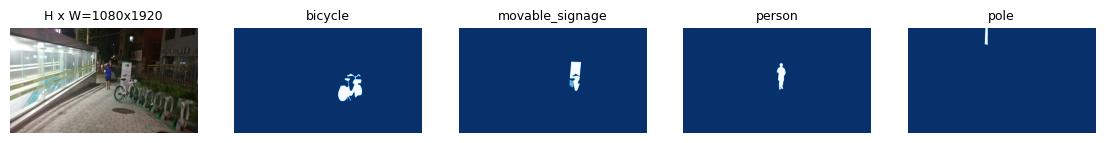

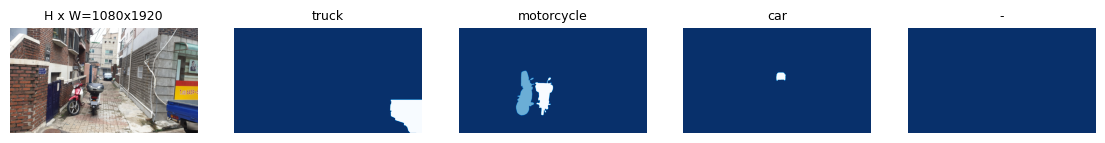

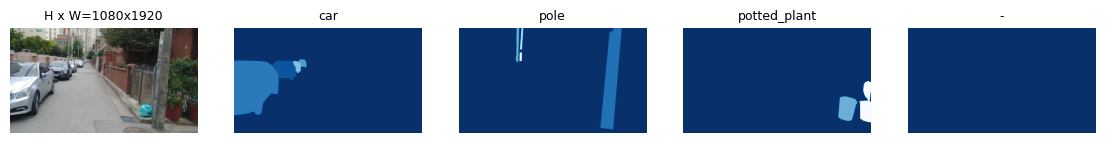

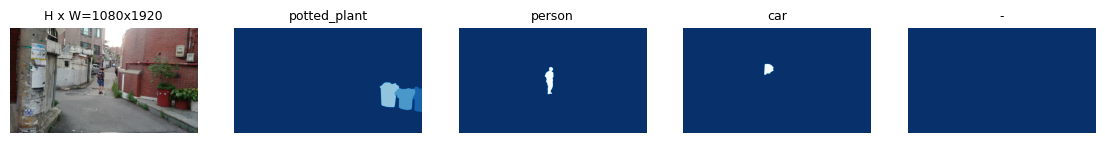

In [9]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2024-07-28 13:19:17.608307: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-07-28 13:19:17.673810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-28 13:19:17.675808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.60GiB deviceMemoryBandwidth: 685.51GiB/s
2024-07-28 13:19:17.675817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-07-28 13:19:17.682081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-07-28 13:19:17.682124: I tensorflow/stream_execut

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

2024-07-27 22:39:22.509076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 22:39:22.509977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-27 22:39:22.511932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.60GiB deviceMemoryBandwidth: 685.51GiB/s
2024-07-27 22:39:22.511957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value

In [11]:
model_path = model.find_last()

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  Mask_RCNN/logs/test20240727T1628/mask_rcnn_test_0142.h5
Re-starting from epoch 142


In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=200, 
            layers='heads'
            )
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 142. LR=0.001

Checkpoint Path: Mask_RCNN/logs/test20240727T1628/mask_rcnn_test_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistrib

2024-07-27 22:39:52.540206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-07-27 22:39:52.954840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2024-07-27 22:39:53.503757: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-07-27 22:39:53.503769: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2024-07-27 22:39:53.503933: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-07-27 22:39:53.520835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
20

  2/500 [..............................] - ETA: 1:18 - batch: 0.5000 - size: 4.0000 - loss: 3.6350 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.8932 - mrcnn_class_loss: 0.6688 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.6064       

2024-07-27 22:39:55.856688: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2024-07-27 22:39:55.856706: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2024-07-27 22:39:55.856719: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2024-07-27 22:39:55.857235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64::/usr/local/cuda-12.3/lib64:
2024-07-27 22:39:55.857320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64::/usr/local/cuda-12.3/lib64:
2024-07-27 22:39:55.857327: E tensorflow/core/profiler/internal/gpu/c

500/500 [==============================] - 79s 142ms/step - batch: 249.5000 - size: 4.0000 - loss: 1.5591 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.7632 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.3126 - val_loss: 2.9926 - val_rpn_class_loss: 0.0601 - val_rpn_bbox_loss: 2.0581 - val_mrcnn_class_loss: 0.2903 - val_mrcnn_bbox_loss: 0.2466 - val_mrcnn_mask_loss: 0.3374
Epoch 144/200
500/500 [==============================] - 58s 116ms/step - batch: 249.5000 - size: 4.0000 - loss: 1.4318 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.7075 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.2840 - val_loss: 3.1299 - val_rpn_class_loss: 0.0444 - val_rpn_bbox_loss: 1.9328 - val_mrcnn_class_loss: 0.4854 - val_mrcnn_bbox_loss: 0.3267 - val_mrcnn_mask_loss: 0.3406
Epoch 145/200
500/500 [==============================] - 60s 120ms/step - batch: 249.5000 - size: 4.0000 - loss: 1.4792 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.7460 - mrcnn_class_l

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=400, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 200. LR=0.0001

Checkpoint Path: Mask_RCNN/logs/test20240727T0534/mask_rcnn_test_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

2024-07-27 10:20:03.658425: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2024-07-27 10:20:03.658440: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2024-07-27 10:20:03.658717: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2024-07-27 10:20:03.773552: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-07-27 10:20:03.773861: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1752] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2024-07-27 10:20:03.804242: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-07-27 10:20:03.821564: I tensorflow

   3/1000 [..............................] - ETA: 2:52 - batch: 1.0000 - size: 3.0000 - loss: 0.3998 - rpn_class_loss: 9.7025e-05 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0705     

2024-07-27 10:20:03.869612: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03
2024-07-27 10:20:03.874561: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03/LAAA.memory_profile.json.gz
2024-07-27 10:20:03.875229: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03Dumped tool data for xplane.pb to Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03/LAAA.xplane.pb
Dumped tool data for overview_page.pb to Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03/LAAA.overview_page.pb
Dumped tool data for input_pipeline.pb to Mask_RCNN/logs/test20240727T0534/plugins/profile/2024_07_27_10_20_03/LAAA.input_pipeline.pb
Dumped tool data for te

1000/1000 [==============================] - 140s 131ms/step - batch: 499.5000 - size: 3.0000 - loss: 0.6016 - rpn_class_loss: 6.3305e-04 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0818 - val_loss: 14.3026 - val_rpn_class_loss: 0.1335 - val_rpn_bbox_loss: 5.4562 - val_mrcnn_class_loss: 0.6773 - val_mrcnn_bbox_loss: 0.2571 - val_mrcnn_mask_loss: 0.6271
Epoch 202/400
1000/1000 [==============================] - 129s 129ms/step - batch: 499.5000 - size: 3.0000 - loss: 0.7340 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0944 - val_loss: 11.1378 - val_rpn_class_loss: 0.0789 - val_rpn_bbox_loss: 4.1139 - val_mrcnn_class_loss: 0.6353 - val_mrcnn_bbox_loss: 0.2414 - val_mrcnn_mask_loss: 0.4994
Epoch 203/400
1000/1000 [==============================] - 129s 129ms/step - batch: 499.5000 - size: 3.0000 - loss: 0.6742 - rpn_class_loss: 8.9623e-04 - rpn_bbox_loss: 0.1

KeyboardInterrupt: 

In [11]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [12]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [25]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  Mask_RCNN/logs/test3/mask_rcnn_test_0100.h5


In [29]:
import skimage
real_test_dir = 'test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

AssertionError: len(images) must be equal to BATCH_SIZE

In [20]:
import os
import numpy as np
import skimage.io
from mrcnn import model as modellib, visualize

real_test_dir = 'test/'
image_paths = [os.path.join(real_test_dir, filename) for filename in os.listdir(real_test_dir) 
               if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']]

batch_size = 3

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for image_batch in batch(image_paths, batch_size):
    images = []
    for image_path in image_batch:
        img = skimage.io.imread(image_path)
        if img.shape[-1] == 4:
            img = img[..., :3]
        images.append(np.array(img))
    
    results = model.detect(images, verbose=1)
    
    for img, r in zip(images, results):
        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    dataset_val.class_names, r['scores'], figsize=(5, 5))


AssertionError: len(images) must be equal to BATCH_SIZE

Processing 4 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (184, 274, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (4, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (4, 46)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (4, 65472, 4)         min:   -0.17712  max:    1.05188  float32


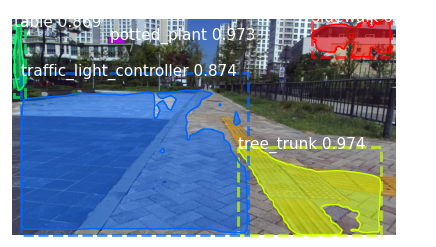

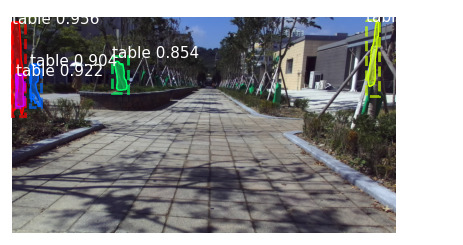

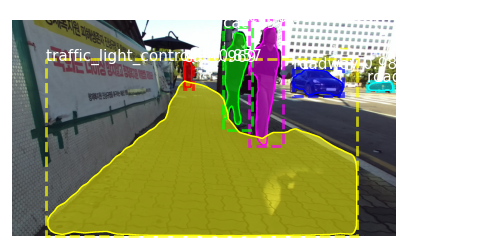

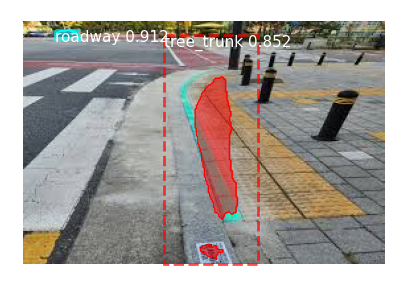

Processing 4 images
image                    shape: (168, 300, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (513, 699, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (4, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (4, 46)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (4, 65472, 4)         min:   -0.17712  max:    1.05188  float32


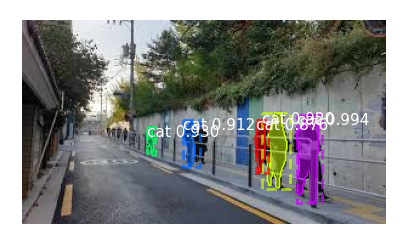

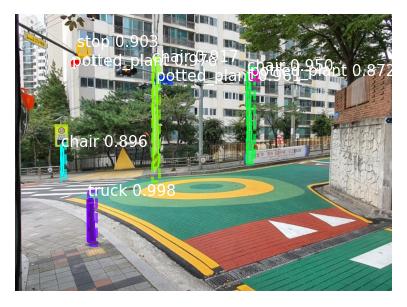

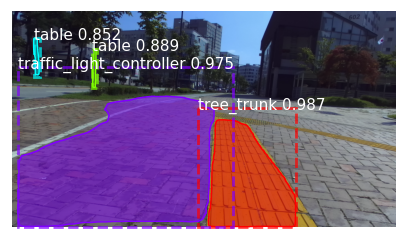

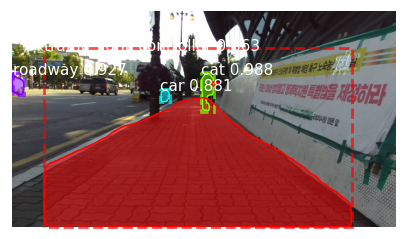

Processing 4 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (348, 512, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (1080, 1920, 3)       min:    0.00000  max:    0.00000  uint8
molded_images            shape: (4, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (4, 46)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (4, 65472, 4)         min:   -0.17712  max:    1.05188  float32


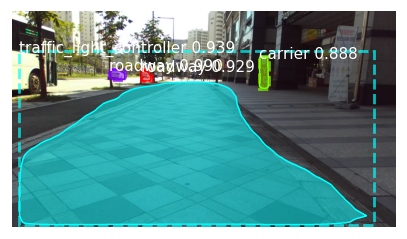

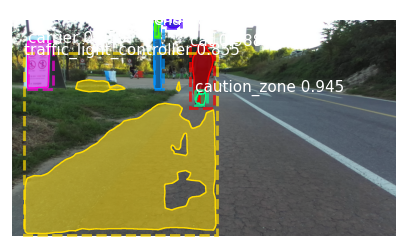

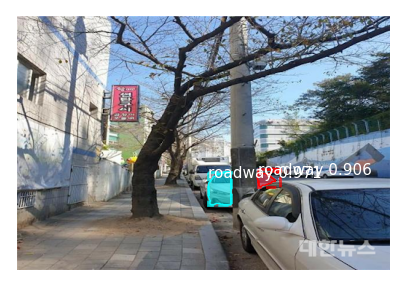

In [27]:
import os
import numpy as np
import skimage.io
from mrcnn import model as modellib, visualize

real_test_dir = 'test/'
image_paths = [os.path.join(real_test_dir, filename) for filename in os.listdir(real_test_dir) 
               if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']]

batch_size = 4

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

for image_batch in batch(image_paths, batch_size):
    images = []
    for image_path in image_batch:
        img = skimage.io.imread(image_path)
        if img.shape[-1] == 4:
            img = img[..., :3]
        images.append(np.array(img))
    
    # If the number of images in the batch is less than batch_size, pad the batch
    if len(images) < batch_size:
        while len(images) < batch_size:
            images.append(np.zeros_like(images[0]))

    results = model.detect(images, verbose=1)
    
    for img, r in zip(images[:len(image_batch)], results[:len(image_batch)]):
        visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                    dataset_val.class_names, r['scores'], figsize=(5, 5))


In [25]:
import os
import numpy as np
import skimage.io
from your_model_library import model, dataset_val, visualize  # 실제 임포트로 대체

real_test_dir = 'test/'
image_paths = [os.path.join(real_test_dir, filename) for filename in os.listdir(real_test_dir) if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']]

batch_size = 4
batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]

for batch in batches:
    images = []
    for image_path in batch:
        img = skimage.io.imread(image_path)
        if img.shape[-1] == 4:
            img = img[..., :3]
        images.append(np.array(img))

    results = model.detect(images, verbose=1)
    for i, r in enumerate(results):
        visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], 
                                    dataset_val.class_names, r['scores'], figsize=(5,5))


ModuleNotFoundError: No module named 'your_model_library'

In [5]:
import numpy as np
import scipy.io
import tensorflow as tf
from mrcnn.config import Config
from mrcnn import model as modellib

# CustomConfig 클래스 정의 (사용자 정의로 설정한 것을 사용)
class CustomConfig(Config):
    NAME = "coco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes

# 모델 설정
config = CustomConfig()

# InferenceConfig 클래스 정의
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Mask R-CNN 모델 로드
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# 마지막으로 학습된 가중치 로드
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# 가중치 가져오기
weights = model.keras_model.get_weights()

# 가중치를 사전 형식으로 변환
weights_dict = {}
for i, weight in enumerate(weights):
    weights_dict[f'weight_{i}'] = weight

# .mat 파일로 저장
scipy.io.savemat('mask_rcnn_weights.mat', weights_dict)


Instructions for updating:
Use fn_output_signature instead


FileNotFoundError: [Errno 2] Could not find model directory under Mask_RCNN\logs

In [8]:
import numpy as np
import scipy.io
import tensorflow as tf
from mrcnn.config import Config
from mrcnn import model as modellib

# Define a configuration class
class CustomConfig(Config):
    NAME = "coco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    NUM_CLASSES = 1 + 33  # COCO dataset has 80 classes

# Create a config instance
config = CustomConfig()

# Load Mask R-CNN model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='.')

# Load weights from the .h5 file
model.load_weights('final_mask_rcnn.h5', by_name=True)

# Extract weights
weights = model.keras_model.get_weights()

# Convert weights to dictionary format
weights_dict = {}
for i, weight in enumerate(weights):
    weights_dict[f'weight_{i}'] = weight

# Save weights to .mat file
scipy.io.savemat('mask_rcnn_weights.mat', weights_dict)


Instructions for updating:
Use fn_output_signature instead


In [16]:
from mrcnn import model as modellib

# Define the configuration for inference
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Initialize the Mask R-CNN model
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='./')

# Load weights from the .h5 file
model.load_weights('final_mask_rcnn.h5', by_name=True)

# Get the Keras model
keras_model = model.keras_model

# Print the summary of the model
keras_model.summary()

# Extract and print the number of layers
num_layers = len(keras_model.layers)
print(f'Number of layers in the model: {num_layers}')

ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED: SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0000000000000001;/job:localhost/replica:0/task:0/device:GPU:0;edge_3530__arg_Placeholder_5494_0_38;0:0
	 [[{{node _arg_Placeholder_5494_0_38/_19397}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[ReadVariableOp_5984/_21757]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED: SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0000000000000001;/job:localhost/replica:0/task:0/device:GPU:0;edge_3530__arg_Placeholder_5494_0_38;0:0
	 [[{{node _arg_Placeholder_5494_0_38/_19397}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored.

In [9]:
from mrcnn import model as modellib

# Define the configuration for inference
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Initialize the Mask R-CNN model
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='./')

# Load weights from the .h5 file
model.load_weights('final_mask_rcnn.h5', by_name=True)

# Get the Keras model
keras_model = model.keras_model

# Print the summary of the model
keras_model.summary()

# Extract and print the number of layers
num_layers = len(keras_model.layers)
print(f'Number of layers in the model: {num_layers}')

Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, None, None,   0          ['input_image[0][0]']            
 D)                             3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d_1[0][0]']       
                                64)                                                       

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101

# Load the ResNet101 model
resnet101_model = ResNet101(weights='imagenet')

# Print the summary of the model
resnet101_model.summary()

# Extract and print the number of layers
num_layers = len(resnet101_model.layers)
print(f'Number of layers in the ResNet101 model: {num_layers}')


Instructions for updating:
Colocations handled automatically by placer.
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                  

In [14]:
from mrcnn import model as modellib

# Define the configuration for inference
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Initialize the Mask R-CNN model
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='./')

# Load weights from the .h5 file
model.load_weights('final_mask_rcnn.h5', by_name=True)

# Get the Keras model
keras_model = model.keras_model

# Print the summary of the model
keras_model.summary()

# Extract layer names from Mask R-CNN
mask_rcnn_layers = [layer.name for layer in keras_model.layers]

# Print the number of layers and first few layer names
print(f'Number of layers in Mask R-CNN: {len(mask_rcnn_layers)}')
print('First few layers in Mask R-CNN:', mask_rcnn_layers[:10])


Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_image[0][0]']            
 D)                             3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d_2[0][0]']       
                                64)                                                       

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101

# Load ResNet101 model
resnet101_model = ResNet101(weights='imagenet')

# Print the summary of ResNet101
resnet101_model.summary()

# Extract layer names from ResNet101
resnet101_layers = [layer.name for layer in resnet101_model.layers]

# Print the number of layers and first few layer names
print(f'Number of layers in ResNet101: {len(resnet101_layers)}')
print('First few layers in ResNet101:', resnet101_layers[:10])


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [16]:
# Convert lists to sets for easier comparison
resnet101_layers_set = set(resnet101_layers)
mask_rcnn_layers_set = set(mask_rcnn_layers)

# Find common and unique layers
common_layers = resnet101_layers_set.intersection(mask_rcnn_layers_set)
unique_to_resnet101 = resnet101_layers_set - mask_rcnn_layers_set
unique_to_mask_rcnn = mask_rcnn_layers_set - resnet101_layers_set

# Print the results
print(f'Common layers between ResNet101 and Mask R-CNN: {common_layers}')
print(f'Layers unique to ResNet101: {unique_to_resnet101}')
print(f'Layers unique to Mask R-CNN: {unique_to_mask_rcnn}')


Common layers between ResNet101 and Mask R-CNN: set()
Layers unique to ResNet101: {'conv4_block7_1_relu', 'conv3_block1_1_bn', 'conv4_block15_1_relu', 'conv4_block18_3_conv', 'conv4_block5_2_relu', 'conv4_block3_2_bn', 'conv4_block11_1_conv', 'conv4_block11_2_conv', 'conv4_block9_out', 'avg_pool', 'conv4_block5_3_bn', 'conv4_block17_3_conv', 'conv3_block2_1_relu', 'conv4_block11_2_relu', 'conv4_block23_1_conv', 'conv4_block21_1_conv', 'conv4_block8_1_conv', 'conv4_block4_2_bn', 'conv4_block15_1_conv', 'conv4_block2_add', 'conv4_block11_3_bn', 'conv4_block21_1_relu', 'conv4_block5_out', 'conv3_block1_out', 'conv4_block9_add', 'conv2_block1_2_relu', 'conv4_block7_2_relu', 'conv4_block12_add', 'conv4_block10_add', 'conv2_block3_2_relu', 'conv4_block19_3_bn', 'conv4_block17_1_bn', 'conv5_block2_3_bn', 'conv4_block21_3_conv', 'conv3_block2_3_conv', 'conv3_block3_1_relu', 'conv4_block14_3_conv', 'conv4_block17_2_conv', 'conv4_block13_1_bn', 'conv4_block17_1_relu', 'conv4_block20_3_conv', 'co